# Chapter 3. Classification

This chapter will be using MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

In [2]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [3]:
X.shape

(70000, 784)

In [4]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [5]:
y.shape

(70000,)

Peeking at one digit from the dataset

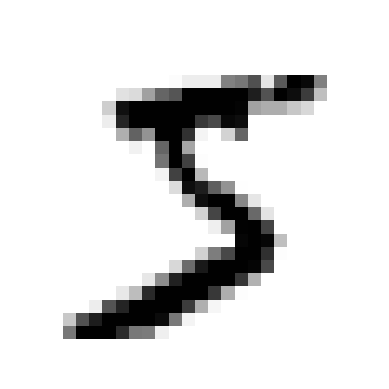

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [7]:
# It is a 5 and that is what the label tell us:
y[0]

'5'

In [8]:
# MNIST is already split into training set (first 60k images) and test set
# (last 10k images)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

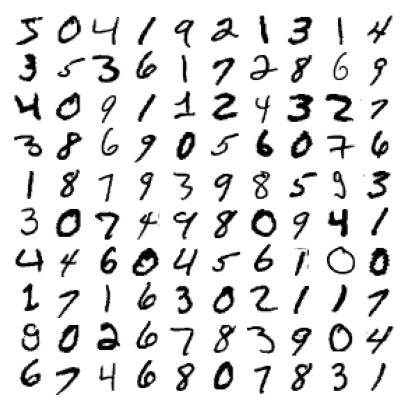

In [9]:
# see 100 images
plt.figure(figsize=(5,5))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10,10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Training a Binary Classifier

Train an ML algorithm to distinguish between 5 and non-5.

In [10]:
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Train a stochastic gradient descent classifier

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
# now we can use it to detect images of the number 5:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

**Measuring Accuracy Using Cross-Validation**

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# creating a dummy classifier and checking its accuracy
from sklearn.dummy import DummyClassifier

# classifier always say the answer is not 5 (False)
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5s detected

False


In [15]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

It has over 90% accuracy! That is because only about 10% of the images are 5s.
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when youa re dealing with skewed datasets (when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM)

**Implementing Cross-Validation**

Occasionally you will need more control over the cross-validation
process than what Scikit-Learn provides off the shelf. In these cases,
you can implement cross-validation yourself. The following code does
roughly the same thing as Scikit-Learn’s cross_val_score() function,
and it prints the same result:

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if the dataset is
                                      # not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum (y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


**Confusion Matrices**

The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pair. For example,
to know the number of times the classifier confused images of 8s with 0s,
you would look at row #8, column #0 of the confusion matrix.

Tom computer the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual target. You can use the cross_val_predict() function:

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict()
performs k-fold cross-validation, but instead of returning the evaluation
scores, it returns the predictions made on each test fold.

In [18]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [19]:
# get confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an *actual class*, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were classifed as non-5s (they are called *true negatives*), while the remaining 687 were wrongly classified as 5s (false positives, also called type I errors). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (*false negatives*, also called type II errors), while the remaining 3,539 were correctly classified as 5s (*true positives*).

In [20]:
# perfect confusion matrix with only true positives and true negatives
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Accuracy of positive predictions (called *precision* of the classifier):
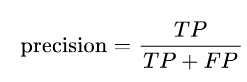


*TP* is the number of true positives, and *FP* is the number of false positives.

Precision is typically used along with another metric named *recall*, also called *sensitivity* or the *true positive rate* (TPR): this is the rationi of positive instances that are correctly detected by the classifer:

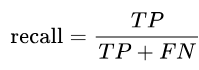

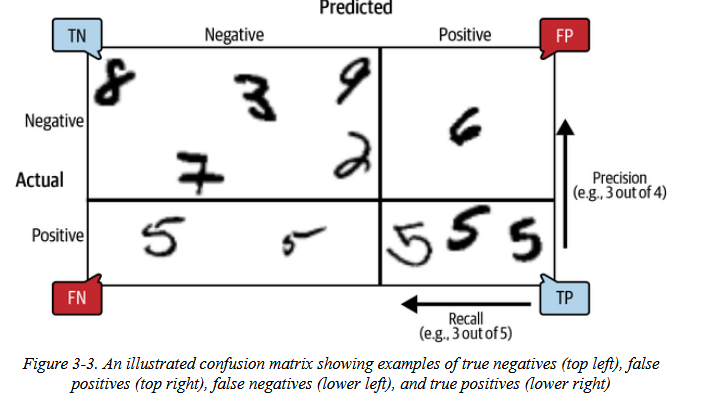

Scikit-Learn provides several functions to compute classifier metrics,
including precision and recall:

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

Now our 5-detector does not look as shiny as it did when we looked at its accuracy. When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric calld the F1 score, especially when you need a metric to compare 2 classifiers. The F1 score is the *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F score if both recall and precision are high.

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

To understand this trade-off, let’s look at how the SGDClassifier makes its
classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the
instance to the positive class; otherwise it assigns it to the negative class.

Raise the threshold and precision incraeses and recall decreases. Conversely, lower the threshold and precision decreases and recall increases.

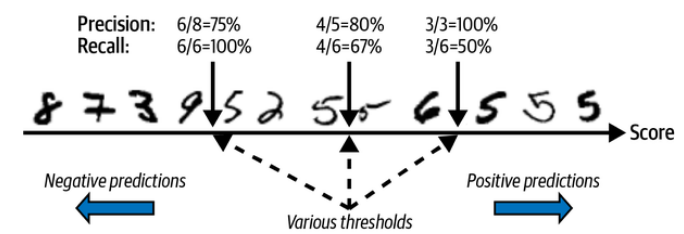

In [24]:
# Sklearn does not let us change the threshold directly but it does give us 
# the scores
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
# low threshold
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
# Raise the threshold
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
# Get all scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
                              cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [28]:
# with theses scores use function below to compute precision and recall
# for all possible thresholds
from sklearn.metrics import precision_recall_curve

# the function adds a last precision of 0 and a last recall of 1,
# corresponding to an infinite threshold
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

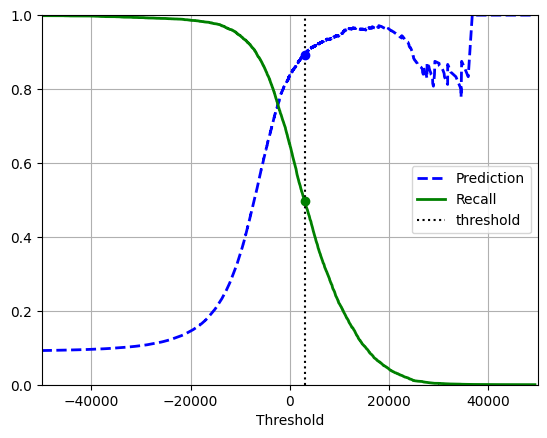

In [29]:
# plot precision and recall as functions of the threshold value while showing 
# the threshold of 3,000
plt.plot(thresholds,precisions[:-1], "b--", label="Prediction", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0,"k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax() # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall (the same threshold is shown):

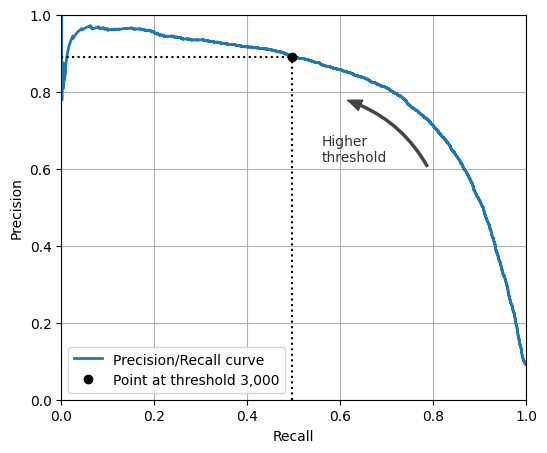

In [30]:
import matplotlib.patches as patches # for the curved arrow

plt.figure(figsize=(6, 5)) 

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0,1,0,1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [31]:
# To select a threshold that gives 90% precision, for example,
# we can search this threshold using NumPy array's argmax() method.
# This returns the first index of the maximum value, which is True here
idx_for_90_precision =  (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [32]:
# To make predictions using our selected threshold:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

# precision and recall
print("Precision:", precision_score(y_train_5, y_train_pred_90))

recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
print("Recall:",recall_at_90_precision)

Precision: 0.9000345901072293
Recall: 0.4799852425751706


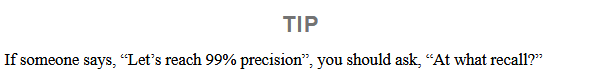

**The ROC Curve**

In [33]:
# use roc_curve() function to compute TPR and FPR
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

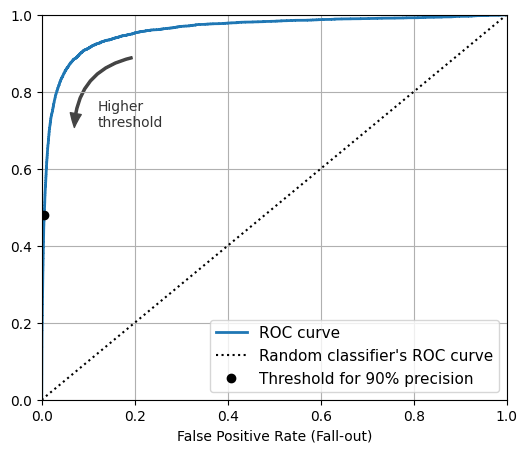

In [34]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0,1],[0,1], "k:", label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3, rad=0.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel("False Positive Rate (Fall-out)")
plt.grid()
plt.axis([0,1,0,1])
plt.legend(loc="lower right", fontsize=11)

plt.show()

ROC AUC (area under the curve)

In [35]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [36]:
# Create RandomForest classifier to compare its PR curve and F1 score
# to those of the SGDClassifier:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [37]:
# use cross val predict to get prediction for every image in the train set
# and get estimated probability
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [38]:
# look at the class probabilities of the the first 2 images in the training set:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [39]:
# second column contains the estimated probabilities for the positive class
# pass them to precision recall curve
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

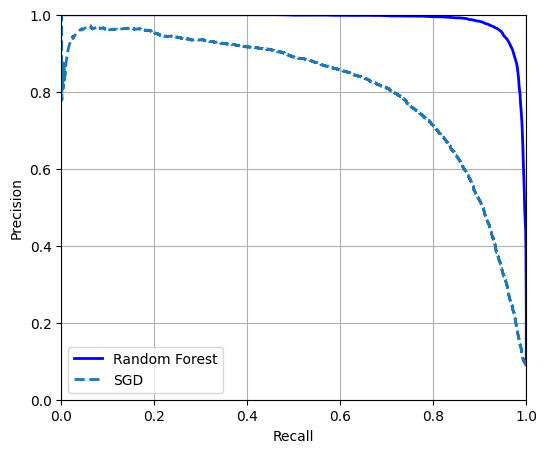

In [40]:
# compare random forest and sgd PR curves
plt.figure(figsize=(6,5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0,1,0,1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [41]:
# Random forest's PR curve looks much better
# how about F1 score and ROC AUC score?
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba ≥ 50%

f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [42]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [43]:
# precision and recall scores
print("Precision:", precision_score(y_train_5, y_train_pred_forest))

print("Recall:", recall_score(y_train_5, y_train_pred_forest))

Precision: 0.9897468089558485
Recall: 0.8725327430363402


## Multiclass Classification

In [44]:
# train SVC on first 2k images for the multiclass classification task
# (10 classes)
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

SVC(random_state=42)

In [45]:
# prediction on a image
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [46]:
# decision function method returns 10 scores per instance: one per class.
# each class gets a score equal to the number of won duels plus or minus a small
# tweak (max ±0.33) to break ties
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [47]:
# highest score is 9.3, and it corresponids to class 5:
class_id = some_digit_scores.argmax()
class_id

5

In [48]:
# if the classes do not match the index of each class in the classes score array
# see the class label array:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [49]:
svm_clf.classes_[class_id]

'5'

In [50]:
# if we want to force scikit-learn to use one-versus-one or one-versus-the-rest
# use OneVsOneClassifier or OneVsRestClassifier classes
from sklearn.multiclass import OneVsRestClassifier

# SVC uses OvO strategy by default
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [51]:
# make a prediction and check the number of trained classifiers:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [52]:
len(ovr_clf.estimators_)

10

In [53]:
# train an SGDClassifier on a multiclass dataset
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [54]:
# Scikit-learn used OvR this time so its decision function method now returns
# one value per class.
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [55]:
# use cross val score to evaluate the model
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Over 85.8% on all test folds. A random classifer would get 10% accuracy. It is good, but we can do better.

In [56]:
# Scaling the inputs
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

See confusion matrix to see the mistakes

In [60]:
# get predictions and save model because I will probably save days on this notebook and do not want to wait for 20 min to rerun everything every time
from sklearn.metrics import ConfusionMatrixDisplay
from joblib import Memory

location = "./cachedir"
memory = Memory(location, verbose=0)
cross_val_predict_cached = memory.cache(cross_val_predict)

y_train_pred = cross_val_predict_cached(sgd_clf, X_train_scaled, y_train, cv=3)

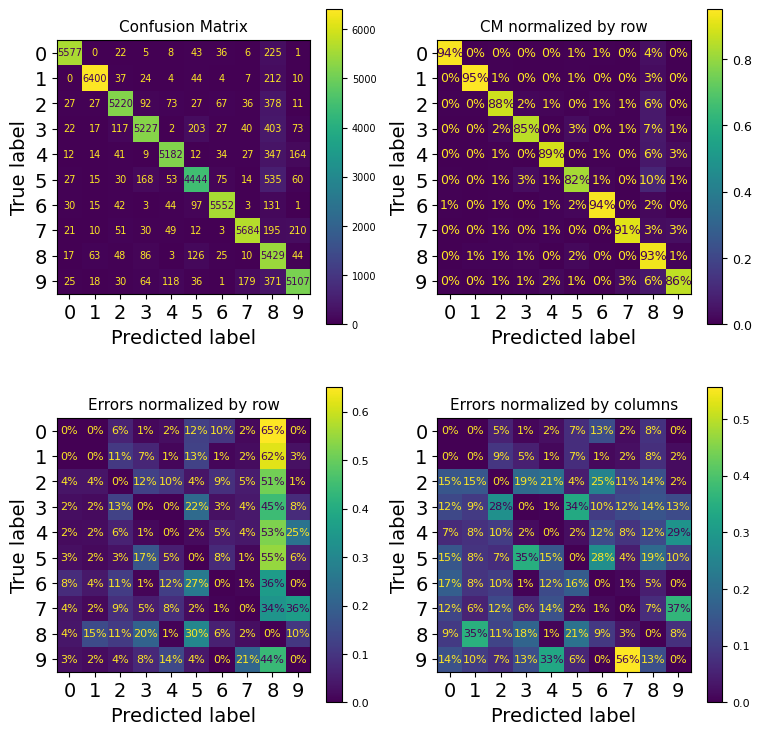

In [76]:
fig, axs = plt.subplots(2,2,figsize=(9,9))

plt.rc("font", size=7)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0][0])
axs[0][0].set_title("Confusion Matrix", fontsize=11)

plt.rc("font", size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0][1],
                                        normalize="true", values_format=".0%")
axs[0][1].set_title("CM normalized by row")

plt.rc("font", size=8)
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1][0],
                            sample_weight=sample_weight,
                            normalize="true", values_format=".0%")
axs[1][0].set_title("Errors normalized by row", fontsize=11)

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1][1],
                            sample_weight=sample_weight,
                            normalize="pred", values_format=".0%")
axs[1][1].set_title("Errors normalized by columns", fontsize=11)
plt.show()
plt.rc("font", size=14) # make fonts great again

In [82]:
# plot 3s and 5s in a confusion matrix style
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

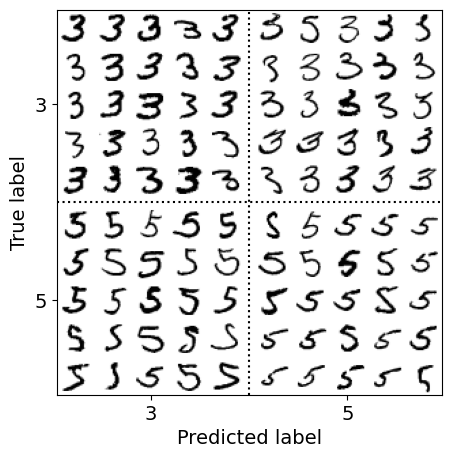

In [87]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0,0)), (X_bb, (1,0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28,28), cmap="binary",
                    extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size /2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Multilabel Classification

In [88]:
# simple example
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= "7")
y_train_odd = (y_train.astype("int8") % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [89]:
# prediction
knn_clf.predict([some_digit])

array([[False,  True]])

In [90]:
# compute average F1 score across all labels:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

Example of Chain Classifier:

In [93]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [94]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classification

In [95]:
# example: add noise to mnist images and the outputs should be the clean
# version of each pixel
np.random.seed(42) # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

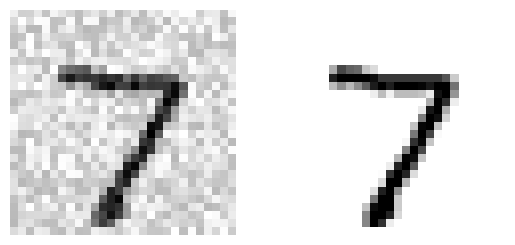

In [96]:
# snooping on test set
plt.subplot(121)
plot_digit(X_test_mod[0])
plt.subplot(122)
plot_digit(y_test_mod[0])

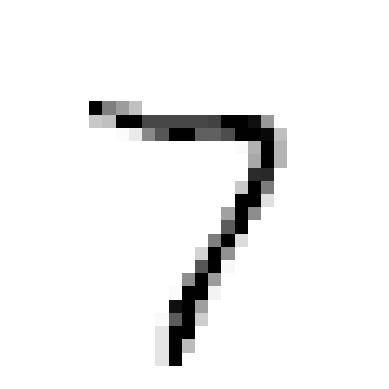

In [98]:
# train a classifier to clean up images
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

# image cleaned up
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

# Exercises

1. Try to build a classifier for the MNIST dataset that achieves over 97%
accuracy on the test set. Hint: the KNeighborsClassifier works quite
well for this task; you just need to find good hyperparameter values
(try a grid search on the weights and n_neighbors hyperparameters).

In [113]:
from sklearn.model_selection import GridSearchCV

# scaled
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
knn = KNeighborsClassifier()
params = {"weights":["uniform", "distance"], "n_neighbors":[3,4,5,7]}
grid_search = GridSearchCV(knn,params, cv=3, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [114]:
import pandas as pd 

df_knn = pd.DataFrame(grid_search.cv_results_)
df_knn[["params","mean_test_score", "rank_test_score"]].sort_values("rank_test_score").head()

,params,mean_test_score,rank_test_score
7,"{'n_neighbors': 4, 'weights': 'distance'}",0.945067,1
11,"{'n_neighbors': 6, 'weights': 'distance'}",0.944267,2
9,"{'n_neighbors': 5, 'weights': 'distance'}",0.943917,3
5,"{'n_neighbors': 3, 'weights': 'distance'}",0.942867,4
15,"{'n_neighbors': 8, 'weights': 'distance'}",0.942433,5


In [121]:
# not scaled
params = {"weights":["uniform", "distance"], "n_neighbors":[3, 4, 5, 7]}
grid_search = GridSearchCV(knn,params, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [122]:
df_knn = pd.DataFrame(grid_search.cv_results_)
df_knn[["params","mean_test_score", "rank_test_score"]].sort_values("rank_test_score").head()

,params,mean_test_score,rank_test_score
5,"{'n_neighbors': 4, 'weights': 'distance'}",0.970350,1
9,"{'n_neighbors': 6, 'weights': 'distance'}",0.969483,2
3,"{'n_neighbors': 3, 'weights': 'distance'}",0.969333,3
7,"{'n_neighbors': 5, 'weights': 'distance'}",0.968600,4
2,"{'n_neighbors': 3, 'weights': 'uniform'}",0.968183,5


In [123]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, grid_search.predict(X_test))

0.9714

2. Write a function that can shift an MNIST image in any direction (left,
right, up, or down) by one pixel. Then, for each image in the training
set, create four shifted copies (one per direction) and add them to the
training set. Finally, train your best model on this expanded training set
and measure its accuracy on the test set. You should observe that your
model performs even better now! This technique of artificially
growing the training set is called data augmentation or training set
expansion.

(756,)
(756,)
0
1
2


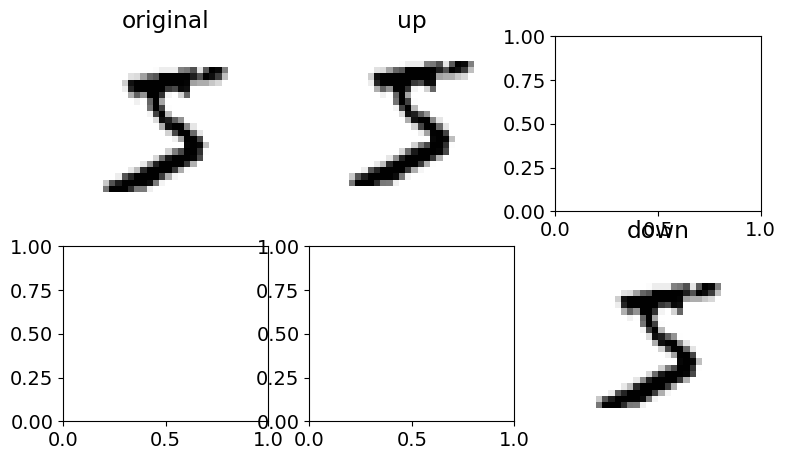

In [136]:
def shift(x):
    # order: up, down, left, right    
    x_up = x.copy()
    print(x_up[:28**2 - 28].shape)
    print(x_up[28:].shape)
    x_up[:28**2 - 28] = x_up[28:]
    x_up[28**2 - 28:] = np.zeros(28, dtype=x.dtype)

    x_down = x.copy()
    x_down[28:] = x_down[:28**2 - 28]
    x_down[:28] = np.zeros(28, dtype=x.dtype)
    return np.array([x,x_up, x_down])

    # x_left = x.copy().reshape(28,28)
    # x_left[:][:-1] = x_left[:][1:]
    # x_left[:][-1] = np.zeros((28,1),dtype=x.dtype)

    # x_right = x.copy().reshape(28, 28)
    # x_right[:][1:] = x_right[:][:-1]
    # x_right[:][0] = np.zeros((1,28), dtype=x.dtype)
    
    # return np.array([x, x_up, x_down, x_left.flatten(), x_right.flatten()])

shifts = shift(some_digit)

titles = ["original", "up", "down", "left", "right"]
fig, axs = plt.subplots(2,3, figsize=(9,5))

for n, img in enumerate(shifts):
    print(n)
    ax = axs[n // 2][n % 3]
    ax.imshow(img.reshape(28,28), cmap="binary")
    ax.axis("off")
    ax.set_title(titles[n])

plt.show()